In [1]:
! pip install --quiet openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00


In [12]:
import nltk
import re
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import logging
import warnings
import numpy as np
import seaborn as sns
from typing import Optional
import tqdm
import time
import psutil
import os
from typing import Optional
from openai import OpenAI
import plotly.express as px
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = 'white'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## config.py

In [2]:
# Global Configuration for Gensim Bigrams
class CONFIG:
    def __init__(self):
        self.MIN_COUNT = 20
        self.THRESHOLD = 10
        self.NO_BELOW = 5
        self.NO_ABOVE = 0.95

        # Global Configuration for Gensm LDA
        self.CHUNKSIZE = 1700 #2000
        self.ITERATIONS = 80 #100
        self.PASSES = 15 #20 # epochs
cfg = CONFIG()

## topic_modling.py
### scripts

In [4]:
import nltk
import re
import gensim
import pandas as pd
import logging
import warnings
import numpy as np
import tqdm

cfg = CONFIG()

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def normalize_corpus(conversations):
    """
    Normalize the corpus by converting to lowercase, removing special entities,
    tokenizing, lemmatizing, and removing stopwords.

    Parameters:
    conversations (list): List of conversations to be normalized.

    Returns:
    list: List of normalized conversations.
    """
    stop_words = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    norm_conversations = []

    print("Normalizing conversations: ")
    for conversation in tqdm.tqdm(conversations):
        conversation = conversation.lower()
        conversation = re.sub(r'\{\{.*?\}\}', '', conversation)
        conversation_tokens = [token.strip() for token in tokenizer.tokenize(conversation)]
        conversation_tokens = [lemmatizer.lemmatize(token) for token in conversation_tokens if not token.isnumeric()]
        conversation_tokens = [token for token in conversation_tokens if len(token) > 1]
        conversation_tokens = [token for token in conversation_tokens if token not in stop_words]
        conversation_tokens = list(filter(None, conversation_tokens))
        if conversation_tokens:
            norm_conversations.append(conversation_tokens)

    return norm_conversations


def gensim_build_bigrams_bow(norm_conversations):
    """
    Build bigrams and Bag of Words representation of the normalized conversations.

    Parameters:
    norm_conversations (list): List of normalized conversations.

    Returns:
    tuple: Tuple containing the Bag of Words corpus, dictionary, and conversations with bigrams.
    """
    bigram = gensim.models.Phrases(norm_conversations, min_count=cfg.MIN_COUNT, threshold=cfg.THRESHOLD, delimiter='_')
    bigram_model = gensim.models.phrases.Phraser(bigram)
    norm_conversations_bigrams = [bigram_model[conversation] for conversation in norm_conversations]
    dictionary = gensim.corpora.Dictionary(norm_conversations_bigrams)
    dictionary.filter_extremes(no_below=cfg.NO_BELOW, no_above=cfg.NO_ABOVE)
    bow_corpus = [dictionary.doc2bow(text) for text in norm_conversations_bigrams]

    return bow_corpus, dictionary, norm_conversations_bigrams

def topic_modeling_by_coherence(bow_corpus, conversations, dictionary, start_topic_count=2, end_topic_count=10, step=1):
    """
    Perform topic modeling and evaluate using coherence scores.

    Parameters:
    bow_corpus (list): Bag of Words corpus.
    conversations (list): Conversations with bigrams.
    dictionary (gensim.corpora.Dictionary): Gensim dictionary.
    start_topic_count (int): Starting number of topics.
    end_topic_count (int): Ending number of topics.
    step (int): Step size for the number of topics.

    Returns:
    tuple: Tuple containing the LDA models, coherence dataframe, and coherence plot.
    """
    lda_models = []
    scores = {"coherence_c_v_scores": [], "coherence_umass_scores": [], "perplexity_scores": [], "warnings": []}

    gensim_logger = logging.getLogger('gensim')
    gensim_logger.setLevel(logging.ERROR)

    print("Fitting the n-topics iteration: ")
    for num_topics in tqdm.tqdm(range(start_topic_count, end_topic_count + 1, step)):
        with warnings.catch_warnings(record=True) as caught_warnings:
            warnings.simplefilter("always")
            lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=cfg.CHUNKSIZE,
                                               alpha='auto', eta='auto', random_state=7, iterations=cfg.ITERATIONS,
                                               num_topics=num_topics, passes=cfg.PASSES, eval_every=None)
            lda_models.append(lda_model)

            # Coherence and perplexity evaluations
            cv_coherence = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, texts=conversations,
                                                        dictionary=dictionary, coherence='c_v').get_coherence()
            scores["coherence_c_v_scores"].append(cv_coherence)

            umass_coherence = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, texts=conversations,
                                                           dictionary=dictionary, coherence='u_mass').get_coherence()
            scores["coherence_umass_scores"].append(umass_coherence)

            perplexity = lda_model.log_perplexity(bow_corpus)
            scores["perplexity_scores"].append(perplexity)

            # Capture warnings
            warning_message = [str(warning.message) for warning in caught_warnings if "updated prior is not positive" in str(warning.message)]
            scores["warnings"].append(warning_message[0] if warning_message else None)

    # Dataframe for coherence scores
    coherence_df = pd.DataFrame({
        'Number of Topics': range(start_topic_count, end_topic_count + 1, step),
        'C_v Score': np.round(scores["coherence_c_v_scores"], 4),
        'UMass Score': np.round(scores["coherence_umass_scores"], 4),
        'Perplexity Score': np.round(scores["perplexity_scores"], 4),
        'Warnings': scores["warnings"]
    })

    return lda_models, coherence_df

## llm_topic_labeling.py

In [5]:

def generate_topic_labels(client, topics_keywords_as_list, context="chatbot conversations"):
    existing_labels = []
    topic_labels = {}

    for topic, keywords in topics_keywords_as_list.items():
        system_prompt = (
            "You are designed to generate concise labels for topics. "
            "These topics are derived from chatbot conversations about {context} using LDA Topic Modeling. "
            "You will be provided with keywords which are the most representative words from the topic. "
            "The first keywords in the list are way more significant for topic assignment of the chat conversation, "
            "while the latter ones decrementally reduce their importance and should be used to provide additional context. "
            "Existing generated labels for other topics are: {existing}. "
            "Your task is to provide a single, pertinent label for each set of keywords representing a topic, "
            "ensuring the label accurately reflects the {context} context of the conversation."
            ).format(
                context=context,
                existing=', '.join(existing_labels) if existing_labels else "None"
            )

        prompt = f"Based on these keywords: {', '.join(keywords)}, suggest a concise topic label."

        chat_completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            max_tokens=10,
            temperature=0.4,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
        )

        generated_label = chat_completion.choices[0].message.content.strip()
        generated_label = ' '.join(word.capitalize() for word in generated_label.split())

        topic_labels[topic] = generated_label
        existing_labels.append(generated_label)

    # Label review and validation
    for topic, label in topic_labels.items():
        topic_details = "\n".join([f"{topic}: '{label}' generated with these keywords: {', '.join(topics_keywords_as_list[topic][:10])}" for topic, label in topic_labels.items()])
        review_prompt = (
            "You are designed to review generated labels for topics. "
            "These topics are derived from chatbot conversations about {context} using LDA Topic Modeling. "
            "The LDA modeling gave the most impactful keywords for topic assignment of the chat conversation, "
            "The first keywords in the list of are way more significant for the topic assignment, "
            "while the latter ones decrementally reduce their importance and should be used to provide additional context only. "
            "The AI generated topics are as follows: \n"
            f"{topic_details}"
            "Holistically considering all these previously generated labels and their keywords, "
            "for each topic suggest an improved label or keep the current label if it's optimal. "
            "Only answer with the new suggested label name or the initial label name if no improvement is needed."
        ).format(
            context=context)

        prompt = f"Considering all the topic labels and their keywords, suggest an improved label or keep the current label for {topic}. Only respond with the label name."

        review_completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            max_tokens=10,
            temperature=0.4,
            messages=[
                {"role": "system", "content": review_prompt},
                {"role": "user", "content": prompt}
            ]
        )

        reviewed_label = review_completion.choices[0].message.content.strip()
        reviewed_label = reviewed_label.replace('"', '').replace("'", "").strip()
        reviewed_label = ' '.join(word.capitalize() for word in reviewed_label.split())
        topic_labels[topic] = reviewed_label

    return topic_labels

## llm_conversations_assessment.py

In [22]:
def evaluate_response(client, corpus_row, context="chatbot conversations"):
    conversation = corpus_row['Conversation']
    topic = corpus_row['Topic Label']

    system_prompt = (
        "You are designed to review question and answer pairs from chatbot conversations about {context}. "
        "You will evaluate the chatbot's response based on the following criteria: "
        "1. Relevance (does the answer address the question?), "
        "2. Accuracy (is the information provided correct? perform a fact-check), "
        "3. Completeness (does the answer cover all necessary aspects of the question?), "
        "4. Conciseness (is the response easy to understand? think Flesch-Kincaid Readability), "
        "5. Tone (is the response engaging and appropriately toned?). "
        "Rate each criterion on a scale of 1 to 5 and give a very short and concise assessment"
        "Respnse format should strictly be as the following example: "
        "1: score \n"
        "2: score \n"
        "3: score \n"
        "4: score \n"
        "5: score \n"
        "Assessment: short and concise assessment. "
    ).format(
        context = context
    )

    prompt = (
        "Review the following conversation related to the topic '{topic}': "
        "'{conversation}'"
    ).format(
        topic = topic,
        conversation = conversation
    )

    gpt_response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.7,
        max_tokens=300,
        messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
    )
    response = gpt_response.choices[0].message.content.strip()

    return response

def parse_llm_evaluation(row):
    scores = {'Relevance': None, 'Accuracy': None, 'Completeness': None, 'Conciseness': None, 'Tone': None, 'Assessment': None}

    try:
        lines = row['LLM Evaluation'].split('\n')
        scores['Relevance'] = int(lines[0].split(':')[1].strip())
        scores['Accuracy'] = int(lines[1].split(':')[1].strip())
        scores['Completeness'] = int(lines[2].split(':')[1].strip())
        scores['Conciseness'] = int(lines[3].split(':')[1].strip())
        scores['Tone'] = int(lines[4].split(':')[1].strip())

        score_values = [scores['Relevance'], scores['Accuracy'], scores['Completeness'], scores['Conciseness'], scores['Tone']]
        scores['Average Score'] = sum(score_values) / len(score_values)

        assessment_index = [i for i, s in enumerate(lines) if 'Assessment:' in s][0]
        scores['Assessment'] = lines[assessment_index].split(':', 1)[1].strip()

    except Exception as e:
        pass
        #print(f"Error parsing LLM evaluation: {e}")

    return pd.Series(scores)


def fit_response_assessment(client, df, context="chatbot conversations"):
    df = df.reset_index(drop=True)
    df['LLM Evaluation'] = df.apply(lambda row: evaluate_response(client, row, context), axis=1)
    score_columns = df.apply(parse_llm_evaluation, axis=1)
    df = pd.concat([df, score_columns], axis=1)
    df = df.drop('LLM Evaluation', axis=1)
    return df



## optibot_modeling.py

In [13]:
class OptiBotModeling:
    def __init__(self,
                 df: pd.DataFrame,
                 api_key,
                 context: str = "chatbot conversations",
                 start_topic_count: int = 3,
                 end_topic_count: int = 10,
                 step: int = 1):

        self.df_conversation = df["conversation"].to_list()
        self.api_key = api_key
        self.context: Optional[str] = context
        self.start_topic_count = int(start_topic_count)
        self.end_topic_count = int(end_topic_count)
        self.step = int(step)
        self._best_lda_model = None
        self._bow_corpus = None
        self._norm_conversations_bigrams = None
        self._topics_df: Optional[pd.DataFrame] = None
        self._topics_df_as_list: Optional[pd.DataFrame] = None
        self._coherence_df: Optional[pd.DataFrame] = None
        self._corpus_topic_df: Optional[pd.DataFrame] = None
        self._assessed_conversations_df: Optional[pd.DataFrame] = None
        self.best_number_topics = None
        self.best_coherence_score = None
        self.execution_time = None
        self.resource_usage = None

    def fit(self):
        start_time = time.time()
        initial_memory_use = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

        norm_conversations = normalize_corpus(self.df_conversation)
        self._bow_corpus, dictionary, self._norm_conversations_bigrams = gensim_build_bigrams_bow(norm_conversations)

        lda_models, self._coherence_df = topic_modeling_by_coherence(
            bow_corpus=self._bow_corpus,
            conversations=self._norm_conversations_bigrams,
            dictionary=dictionary,
            start_topic_count=self.start_topic_count,
            end_topic_count=self.end_topic_count
        )

        best_model_idx = self._coherence_df['C_v Score'].idxmax()
        self._best_lda_model = lda_models[best_model_idx]
        self.best_number_topics = self._coherence_df['Number of Topics'].iloc[best_model_idx]
        self.best_coherence_score = self._coherence_df['C_v Score'].iloc[best_model_idx]

        lda_models = None # <-- Garbage collection
        self._fit_topics_on_data()

        end_memory_use = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        self.execution_time = round(time.time() - start_time, 3)
        self.resource_usage = round(end_memory_use - initial_memory_use, 3)  # in MB

    def _fit_topics_on_data(self):
        # Check if the model is fitted
        if self._best_lda_model is None:
            raise ValueError("Model not fitted. Call 'fit' before this method.")

        print("Fitting topics on the data...")
        # Topic term extraction and dataframe creation
        topics = [[(term, round(wt, 3))
                    for term, wt in self._best_lda_model.show_topic(n, topn=20)]
                        for n in range(0, self._best_lda_model.num_topics)]

        self._topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                                  for topic in topics],
                             columns=['Terms per Topic'],
                             index=['Topic'+str(t) for t in range(1, self._best_lda_model.num_topics+1)]
                             )

        self._topics_df_as_list = pd.DataFrame([[topic] for topic in [[term for term, wt in topic] for topic in topics]],
                                  columns=['Terms per Topic'],
                                  index=['Topic'+str(t) for t in range(1, self._best_lda_model.num_topics+1)])

        tm_results = self._best_lda_model[self._bow_corpus]
        corpus_topics = [sorted(topics, key=lambda record: -record[1])[0]
                            for topics in tm_results]

        # Integrate topic modeling results into original conversations
        self._corpus_topic_df = pd.DataFrame()
        self._corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
        self._corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
        self._corpus_topic_df['Conversation'] = self.df_conversation

        # Generate topic labels using the LLM
        client = create_openai_client(self.api_key)

        print("Generating topic labels...")
        topics_keywords_as_list = self._topics_df_as_list.to_dict()["Terms per Topic"]
        topic_labels = generate_topic_labels(client, topics_keywords_as_list, self.context)
        def map_topic_label(topic_number):
            return topic_labels.get(f"Topic{topic_number}", "Unknown Topic")

        self._corpus_topic_df['Topic Label'] = self._corpus_topic_df['Dominant Topic'].apply(map_topic_label)
        self._corpus_topic_df.insert(1, 'Topic Label', self._corpus_topic_df.pop('Topic Label'))
        self._topics_df['Topic Label'] = self._topics_df.index.map(topic_labels)
        self._topics_df.insert(0, 'Topic Label', self._topics_df.pop('Topic Label'))

        # Assess the conversation responses with the LLM
        print("Assessing conversation responses...")
        self._assessed_conversations_df = fit_response_assessment(client, self._corpus_topic_df.sample(500), self.context)

    def show_coherence_plot(self, save=False):
        if self.coherence_df is None:
            raise ValueError("Topics not generated. Call 'fit' to generate topics.")

        coherence_scores = self.coherence_df["C_v Score"]
        max_score_index = coherence_scores.idxmax()
        max_score = coherence_scores[max_score_index]
        max_score_topic = self.start_topic_count + self.step * max_score_index

        fig, ax = plt.subplots(figsize=(12, 6))
        x_values = range(self.start_topic_count, self.end_topic_count + 1, self.step)
        ax.plot(x_values, coherence_scores, c='r')
        ax.axhline(y=0.5, c='k', linestyle='--', linewidth=2)
        ax.set_xlabel('Number of Topics')
        ax.set_ylabel('Coherence C_v Score')
        ax.set_title('Topic Coherence')
        ax.set_facecolor('#f0f0f0')
        fig.patch.set_facecolor('white')
        ax.grid(True)
        ax.scatter(max_score_topic, max_score, s=500, edgecolors='blue', facecolors='none', linewidths=5, zorder=5) #color='blue',
        if save:
            fig.savefig('coherence_plot.png', bbox_inches='tight')

        return fig

    def show_topic_distribution_plot(self, save=False):
        df_plot = self._corpus_topic_df
        topic_group = df_plot.groupby(['Dominant Topic', 'Topic Label']).size().reset_index(name='Count')
        topic_group['Percentage'] = (topic_group['Count'] / topic_group['Count'].sum()) * 100
        topic_group['Label'] = topic_group['Dominant Topic'].astype(str) + ' ' + topic_group['Topic Label']
        topic_group = topic_group.sort_values(by='Percentage', ascending=False)
        fig = px.bar(topic_group, x='Label', y='Count',
                    text=np.round(topic_group['Percentage'], 2),
                    labels={'Count': 'Count', 'Label': 'Topic'},
                    title='')
        fig.update_traces(texttemplate='%{text}%', textposition='outside',
                        hovertemplate='<b>Topic Number</b>: %{x}<br>' +
                                        '<b>Topic Label</b>: %{customdata}<br>' +
                                        '<b>Count</b>: %{y} of ' + str(topic_group['Count'].sum()) + '<br>' +
                                        '<b>Percentage</b>: %{text}%',
                        customdata=topic_group['Topic Label'],
                        hoverlabel=dict(font=dict(size=17)),
                        marker_color='#4C72B0')
        fig.update_layout(
            xaxis_title='Topic Number',
            yaxis_title='Count',
            plot_bgcolor='#f0f0f0',
            paper_bgcolor='white',
            margin=dict(l=40, r=40, t=40, b=40),
            xaxis={'tickmode': 'array',
                'tickvals': topic_group['Label'],
                'ticktext': [f"{row['Dominant Topic']}" for _, row in topic_group.iterrows()],
                'title_font': {'color': 'black'},
                'tickfont': {'color': 'black'}},
            yaxis={'title_font': {'color': 'black'},
                'tickfont': {'color': 'black'}},
            title={'text': 'Distribution of Topics by Label', 'font': {'color': 'black'}}
        )

        return fig

    @property
    def topics_df(self) -> pd.DataFrame:
        if self._topics_df is None:
            raise ValueError("Topics not generated. Call 'fit' to generate topics.")
        return self._topics_df

    @property
    def topics_df_as_list(self) -> pd.DataFrame:
        if self._topics_df is None:
            raise ValueError("Topics not generated. Call 'fit' to generate topics.")
        return self._topics_df_as_list

    @property
    def corpus_topic_df(self) -> pd.DataFrame:
        if self._corpus_topic_df is None:
            raise ValueError("Corpus topic not generated. Call 'fit' to generate corpus topics.")
        return self._corpus_topic_df

    @property
    def coherence_df(self) -> pd.DataFrame:
        if self._coherence_df is None:
            raise ValueError("Corpus topic not generated. Call 'fit' to generate corpus topics.")
        return self._coherence_df

    @property
    def coherence_plot(self) -> pd.DataFrame:
        if self._coherence_plot is None:
            raise ValueError("Corpus topic not generated. Call 'fit' to generate corpus topics.")
        return self._coherence_plot

    @property
    def assessed_conversations_df(self) -> pd.DataFrame:
        if self._assessed_conversations_df is None:
            raise ValueError("ACorpus topic not generated. Call 'fit' to generate corpus topics.")
        return self._assessed_conversations_df

## load_data.py

In [7]:
def merge_multiple_qa_columns(df, question_cols, answer_cols):
    df['conversation'] = "Question: " + df[question_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1) + " Answer: " + df[answer_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    return df

def extract_unified_column(df, col):
    df["conversation"] = df[col]
    return df


## clients.py

In [11]:
def create_openai_client(api_key):
    client = OpenAI(api_key=api_key)
    return client

## Final Insights with LLM Prompting

In [8]:
## code

In [15]:
# Colab Requirements
! pip install --quiet datasets
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

from datasets import load_dataset
dataset = load_dataset("ruslanmv/ai-medical-chatbot")
medical_ai_df = dataset['train'].to_pandas()
medical_ai_df = merge_multiple_qa_columns(medical_ai_df, ["Description", "Patient"], ["Doctor"])
medical_ai_df = medical_ai_df.sample(50000).reset_index(drop=True)

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

In [23]:
context = "General medical questions"
medical_ai_topics = OptiBotModeling(medical_ai_df, userdata.get('OPENAI_API_KEY'), context=context, start_topic_count=14, end_topic_count=14)
medical_ai_topics.fit()

Normalizing conversations: 


100%|██████████| 50000/50000 [01:08<00:00, 729.08it/s]


Fitting the n-topics iteration: 


100%|██████████| 1/1 [07:40<00:00, 460.84s/it]


Fitting topics on the data...
Generating topic labels...
Assessing conversation responses...


In [29]:
print(medical_ai_topics.assessed_conversations_df.shape)
medical_ai_topics.assessed_conversations_df.sample(10)

(500, 11)


,Dominant Topic,Topic Label,Contribution %,Conversation,Accuracy,Assessment,Average Score,Completeness,Conciseness,Relevance,Tone
406,8,Medical Consultation And Diagnosis,48.41,Question: Can running and training be done dur...,2.0,The response is relevant but lacks accuracy an...,2.0,2.0,2.0,2.0,2.0
280,12,Diagnostic Blood Tests For Kidney And Liver Fu...,92.11,Question: Q. Why do periods get delayed after ...,1.0,The response is completely irrelevant to the o...,1.2,1.0,1.0,1.0,2.0
83,6,Skin Rash And Lump Concerns,44.99,Question: How can painful lump in arm and stom...,2.0,The response provided some relevant informatio...,1.8,1.0,2.0,2.0,2.0
383,3,Musculoskeletal Pain Causes,67.01,Question: What causes severe pain in the hip r...,2.0,The response provides some insight into possib...,2.4,2.0,3.0,2.0,3.0
239,3,Musculoskeletal Pain Causes,32.89,Question: Suggest treatment for swollen and pa...,2.0,"The response lacks relevance, accuracy, and co...",1.6,1.0,2.0,1.0,2.0
438,3,Musculoskeletal Pain Causes,43.22,Question: Suggest treatment for sharp lower ba...,2.0,The response provides some relevant informatio...,2.6,2.0,3.0,3.0,3.0
437,12,Diagnostic Blood Tests For Kidney And Liver Fu...,57.25,"Question: Liver test done, shows albumin serum...",5.0,"The response is highly relevant, accurate, com...",5.0,5.0,5.0,5.0,5.0
458,6,Skin Rash And Lump Concerns,29.31,Question: What causes lump under the skin on t...,3.0,The response is relevant and provides a potent...,3.4,4.0,3.0,4.0,3.0
268,6,Skin Rash And Lump Concerns,36.21,Question: What does a lump in the vagina indic...,3.0,The response provides a possible explanation f...,3.0,2.0,3.0,4.0,3.0
174,8,Medical Consultation And Diagnosis,42.76,Question: What causes sharp pain in center of ...,2.0,The response is somewhat relevant but lacks ac...,2.2,1.0,3.0,2.0,3.0


In [63]:
df = medical_ai_topics.assessed_conversations_df
topic_scores = df.groupby('Topic Label')['Average Score'].mean().reset_index()
worst_topics = topic_scores.nsmallest(3, 'Average Score')
topic_scores

,Topic Label,Average Score
0,Cancer Treatment Options,2.440000
1,Contraceptive Pill Usage And Health Concerns,4.000000
2,Dental Infection And Swelling Concerns,3.000000
3,Diagnostic Blood Tests For Kidney And Liver Fu...,2.530233
4,Drug Use And Long-term Effects: Tb And,3.333333
5,Fertility Treatment And Reproductive Health,3.340000
6,Medical Consultation And Diagnosis,2.679365
7,Medication Usage And Treatment Recommendations,2.867692
8,Menstrual Cycle And Pregnancy Concerns,2.752381
9,Musculoskeletal Pain Causes,2.522034


In [60]:
def summarize_assessments(client, topic_label, df, context):
    assessments = " ".join(df[df['Topic Label'] == topic_label]['Assessment'].tolist())
    max_length = 2048
    if len(assessments) > max_length:
        assessments = assessments[:max_length]

    system_prompt = (
        "You are designed to summarize assessments created by an LLM based on 5 criteria: "
        "Relevance, Accuracy, Completeness, Conciseness, and Tone. "
        "The goal of the assessment is to provide the user with a clear indication of "
        "what could be improved on the topic being offered for review. "
        "Think about the possibilities that can do, considering these assessments "
        "come from an evaluation of an AI chatbot in the context of {context}."
    ).format(context=context)

    prompt = "Provide a summary of the following assessments for the topic '{topic_label}': {assessments}".format(
        topic_label=topic_label, assessments=assessments)

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.7,
        max_tokens=300,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ]
    )

    summary = response.choices[0].message.content.strip()
    return summary

def analyze_topics(df, api_key, num_topics, best_or_worst, context="Medical questions"):
    client = create_openai_client(api_key)
    topic_scores = df.groupby('Topic Label')['Average Score'].mean().reset_index()
    selected_topics = topic_scores.nlargest(num_topics, 'Average Score') if best_or_worst == 'best' else topic_scores.nsmallest(num_topics, 'Average Score')

    analysis_results = {}

    for topic in selected_topics['Topic Label']:
        topic_data = df[df['Topic Label'] == topic]
        topic_scores = topic_data[['Relevance', 'Accuracy', 'Completeness', 'Conciseness', 'Tone']].mean()

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.bar(topic_scores.index, topic_scores.values, color='#4C72B0')
        ax.set_xlabel('Criteria')
        ax.set_ylabel('Average Score')
        ax.set_title(f'Average Scores for {topic}')
        ax.set_facecolor('#f0f0f0')
        fig.patch.set_facecolor('white')
        ax.grid(True)
        plt.xticks(rotation=45)
        plt.ylim(0, 5)

        summary = summarize_assessments(client, topic, df, context)
        analysis_results[topic] = {'figure': fig, 'summary': summary}

        plt.close(fig)

    return analysis_results

Topic: Pediatric Health And Development Concerns
Summary: In summary, the assessments highlight several areas for improvement in the AI chatbot's responses on Pediatric Health And Development Concerns. The responses lack relevance, accuracy, completeness, conciseness, and an appropriate tone. Suggestions include providing detailed guidance on specific issues, ensuring accuracy in medical information, offering more comprehensive advice, being concise, and maintaining a professional yet empathetic tone. Specific improvements needed include addressing user queries directly, providing accurate medical advice, offering specific information on potential causes, and being more focused and informative in responses.



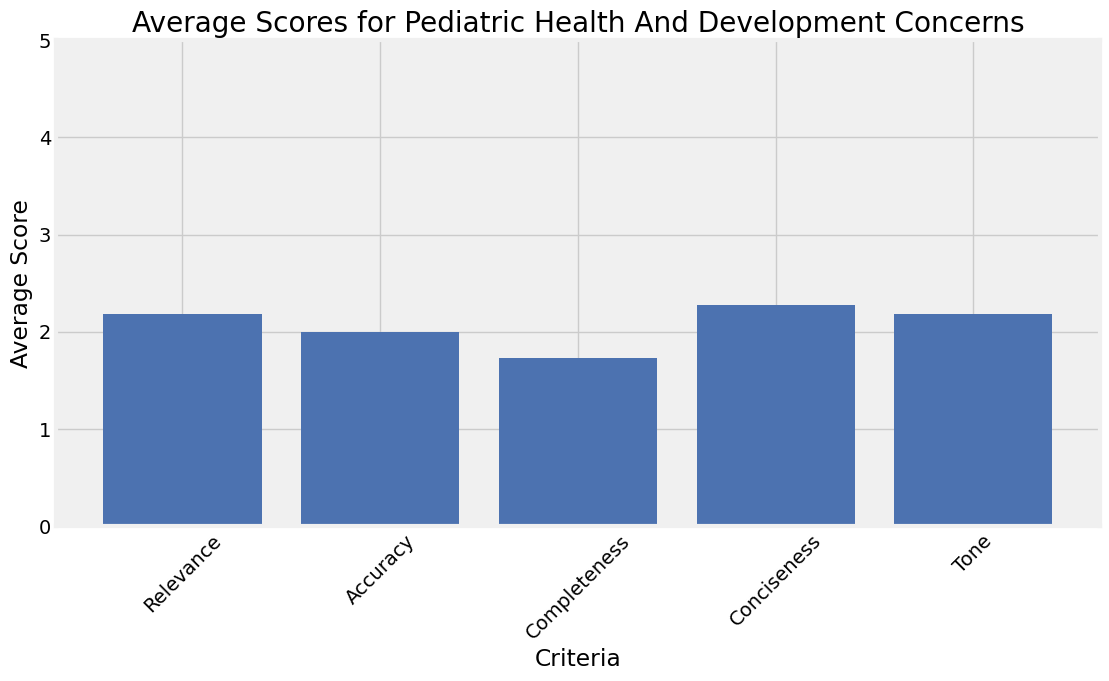





Topic: Sexual Health And Mental Well-being Concerns
Summary: Overall, the assessments indicate that the response on 'Sexual Health And Mental Well-being Concerns' is relevant and accurate in addressing psychological causes, but it could be more complete by considering physical factors. However, the response lacks relevance, accuracy, completeness, conciseness, and an engaging tone when addressing questions about red bumps around a child's neck, pooping blood after eating spicy food, and suggesting inappropriate methods without addressing underlying concerns sensitively or professionally. Improvements are needed in providing accurate, relevant, complete, concise, and engaging responses with a professional and caring tone while addressing specific issues.



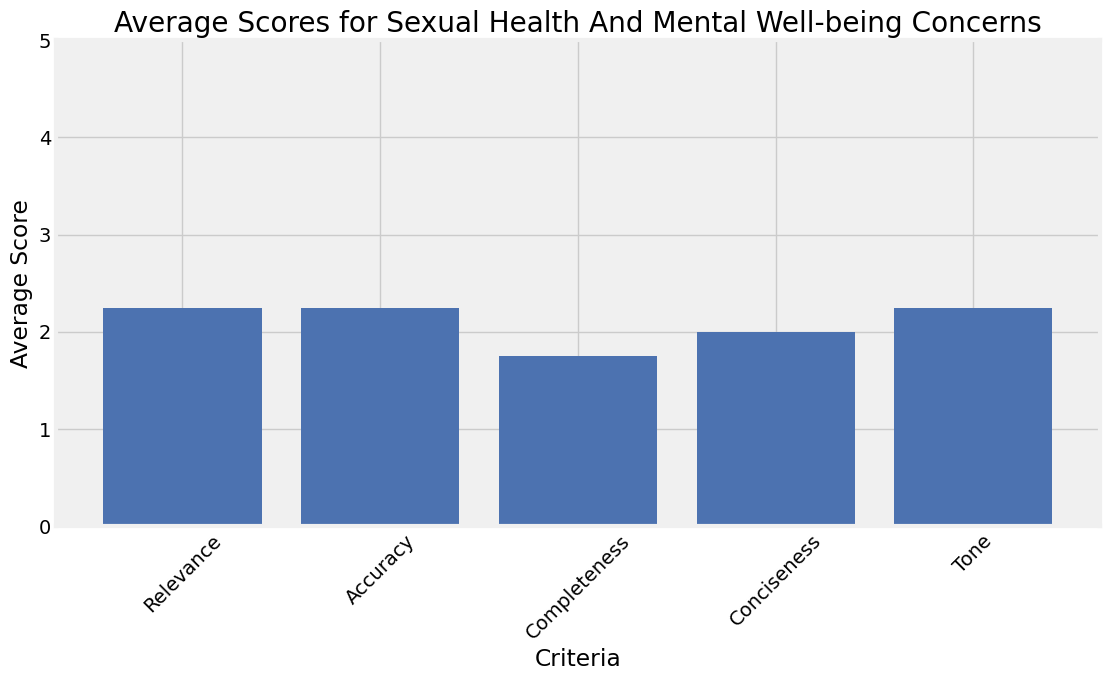





Topic: Cancer Treatment Options
Summary: In the assessments provided on the topic of 'Cancer Treatment Options,' the responses are relevant, accurate, and mostly complete. However, they lack information on other treatment options and could benefit from being more concise and engaging in tone. Regarding the discussion on the poisonous effects of phenol ingestion, the responses lack clarity, accuracy, and completeness. They fail to address potential risks, symptoms, side effects, and necessary steps in such scenarios. Additionally, the responses lack specific information on treatment options and survival rates for esophageal cancer, as well as details on alternative treatments like Ayurveda. While the tone is empathetic, the information provided is not sufficiently detailed or comprehensive.



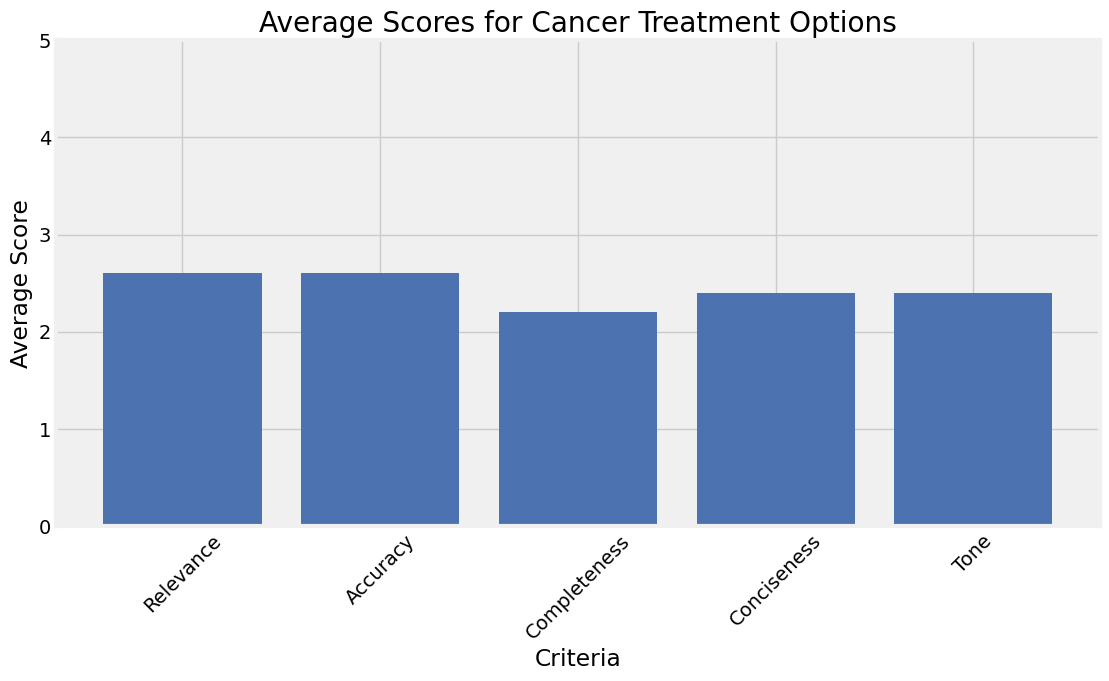

In [59]:
df = medical_ai_topics.assessed_conversations_df
results = analyze_topics(df, api_key, 3, 'worst')

for topic, content in results.items():
    print(f"Topic: {topic}")
    print(f"Summary: {content['summary']}\n")
    display(content['figure'])
    print("\n\n\n")